In [25]:
%%time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


CPU times: user 727 ms, sys: 696 ms, total: 1.42 s
Wall time: 6.48 s


In [26]:
%%time
# 셔플, 미니배치, 프리페치 파이프라인 코드 삽입 및 batch_size = 64 로 증가
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

CPU times: user 1.37 s, sys: 1.81 s, total: 3.18 s
Wall time: 3.18 s


In [27]:
%%time
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [28]:
%%time
model = ResNet18()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 32, 32, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 32, 32, 64)   256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 32, 32, 64)   0           batch_normalization_60[0][0]     
____________________________________________________________________________________________

In [29]:
%%time
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CPU times: user 4.89 ms, sys: 1.01 ms, total: 5.9 ms
Wall time: 4.89 ms


In [30]:
%%time
# 학습 루프
history = model.fit(train_dataset, batch_size=batch_size, epochs=100)
test_loss, test_acc = model.evaluate(x_test, y_test)

# 모델 평가
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/100
782/782 [==============================] - 52s 64ms/step - loss: 1.2107 - accuracy: 0.5656
Epoch 2/100
782/782 [==============================] - 50s 63ms/step - loss: 0.7206 - accuracy: 0.7473
Epoch 3/100
782/782 [==============================] - 50s 64ms/step - loss: 0.5370 - accuracy: 0.8141
Epoch 4/100
782/782 [==============================] - 50s 63ms/step - loss: 0.4231 - accuracy: 0.8530
Epoch 5/100
782/782 [==============================] - 50s 64ms/step - loss: 0.3252 - accuracy: 0.8844
Epoch 6/100
782/782 [==============================] - 50s 64ms/step - loss: 0.2412 - accuracy: 0.9144
Epoch 7/100
782/782 [==============================] - 50s 63ms/step - loss: 0.1757 - accuracy: 0.9386
Epoch 8/100
782/782 [==============================] - 50s 63ms/step - loss: 0.1309 - accuracy: 0.9529
Epoch 9/100
782/782 [==============================] - 50s 64ms/step - loss: 0.1057 - accuracy: 0.9624
Epoch 10/100
782/782 [==============================] - 50s 63ms/step - l

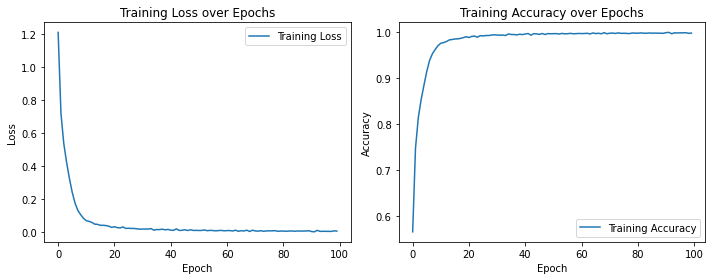

CPU times: user 546 ms, sys: 241 ms, total: 786 ms
Wall time: 396 ms


In [31]:
%%time
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 두 번째 셀에 셔플, 미니배치, 프리페치 파이프라인 코드 삽입 및 batch_size = 64 로 증가
# 그에 맞게 일부 코드 간단 수정
# 에폭 100회 연산 시간 : 1: 24 : 19
# Train acc : 0.99
# Test acc : 0.84
# Test loss : 1.1584
# Baseline의 평균 에폭 시간이 61초 였는데 평균 에폭 시간이 50초로 1/6 감소
# Test02를 통해 더 감소 하는지 체크 해볼 예정